In [37]:
from plugins.calibration.sn_calibration_baseline.camera import Camera
from scipy.signal import savgol_filter
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
import os
import numpy as np

# plt.rcParams['figure.figsize'] = [15, 15]

In [38]:
camParamsPath = "Labels-GameState360.json"
imgPath = 'Images/360/'
maskPath = 'out360/tta/'
imgNum = 500

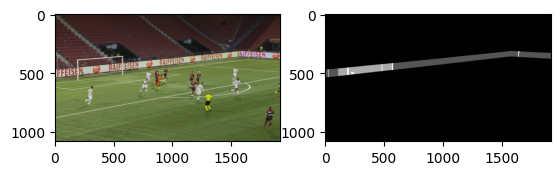

In [39]:
with open(camParamsPath, "r") as f:
	camParams = json.load(f)["annotations"]
camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
cam = Camera()
cam.from_json_parameters(camParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

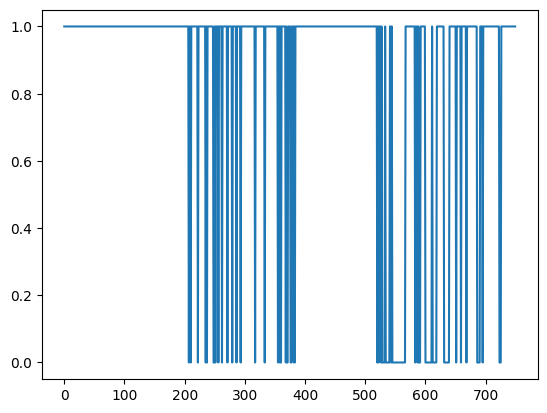

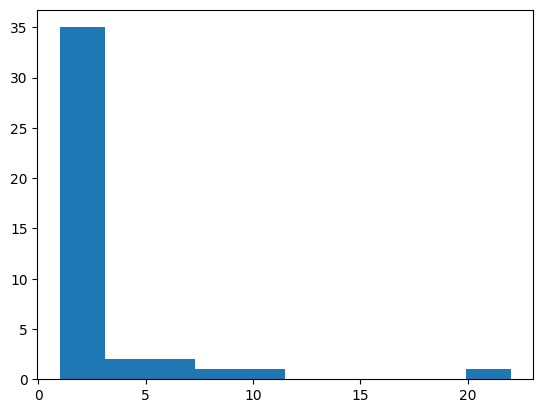

In [40]:
completeParams = np.zeros(len(camParams), dtype=np.bool_)
distOfNonCompleteParams = []
currDist = 0
for i, params in enumerate(camParams):
	if type(params) is dict:
		completeParams[i] = True
		if currDist > 0:
			distOfNonCompleteParams.append(currDist)
			currDist = 0
	else:
		completeParams[i] = False
		currDist += 1

plt.plot(completeParams)
plt.show()
plt.hist(distOfNonCompleteParams)
plt.show()

In [41]:
np.sort(distOfNonCompleteParams)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,
        3,  5,  5,  7,  7,  9, 11, 22])

In [42]:
sum(distOfNonCompleteParams)

108

In [43]:
# For later, to 'remove' bad values of camParams and replace them with a linear interpolation
for param in camParams:
	if type(param) == dict:
		tmpCompleteParam = param
		break
isNonCompleteParams = np.array([type(x) != dict for x in camParams])
posNonCompleteParams = np.where(isNonCompleteParams)[0]

In [44]:
if type(camParams[0]) == type(None):
	idx = 1
	while type(camParams[idx]) != dict:
		idx += 1
	camParams[0] = camParams[idx]
if type(camParams[0]) == list:
	idx = 1
	while type(camParams[idx]) != dict:
		idx += 1
	cam.from_json_parameters(camParams[idx])
	cam.from_homography(camParams[0])
	camParams[0] = cam.to_json_parameters()
for i in range(1, len(camParams)):
    if type(camParams[i]) == type(None):
        camParams[i] = camParams[i - 1]
    elif type(camParams[i]) == list:
        cam.from_json_parameters(camParams[i - 1])  # the homography won't give info about some camera parameters such as the distortions, so we take the previous camera parameters as a starting point
        cam.from_homography(camParams[i])
        camParams[i] = cam.to_json_parameters()

In [45]:
indCamParams = {
	"pan_degrees": [x["pan_degrees"] for x in camParams],
	"tilt_degrees": [x["tilt_degrees"] for x in camParams],
	"roll_degrees": [x["roll_degrees"] for x in camParams],
	"position_meters": [x["position_meters"] for x in camParams],
	"x_focal_length": [x["x_focal_length"] for x in camParams],
	"y_focal_length": [x["y_focal_length"] for x in camParams],
	"principal_point": [x["principal_point"] for x in camParams],
	"radial_distortion": [x["radial_distortion"] for x in camParams],
	"tangential_distortion": [x["tangential_distortion"] for x in camParams],
	"thin_prism_distortion": [x["thin_prism_distortion"] for x in camParams]
}
for key in indCamParams:
	indCamParams[key] = np.array(indCamParams[key])
indCamParamsOrig = deepcopy(indCamParams)

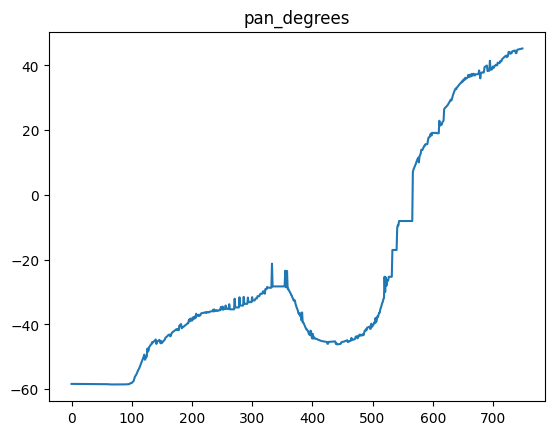

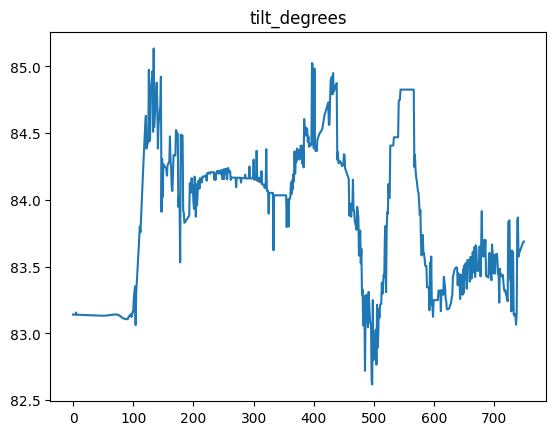

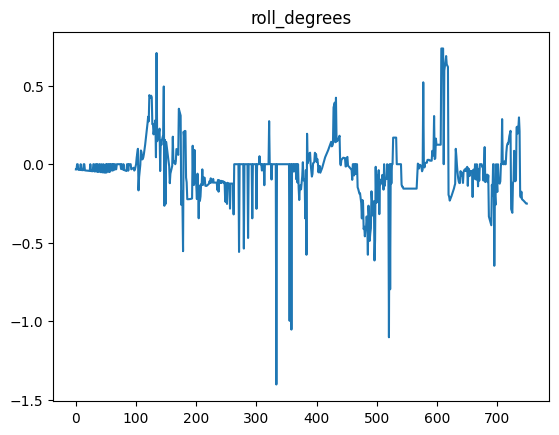

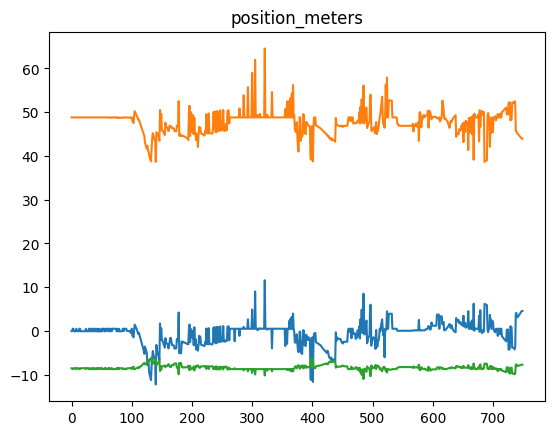

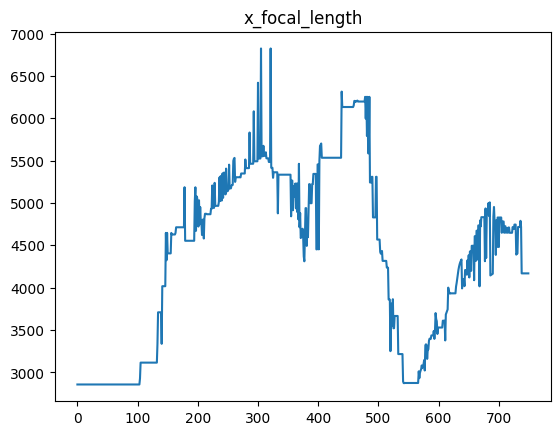

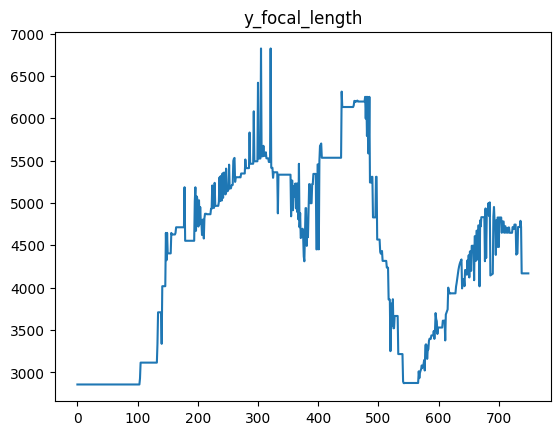

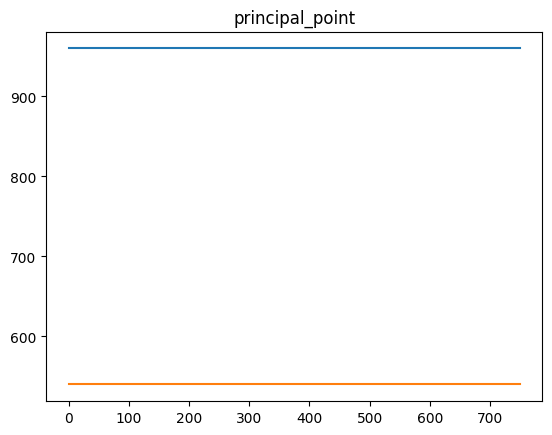

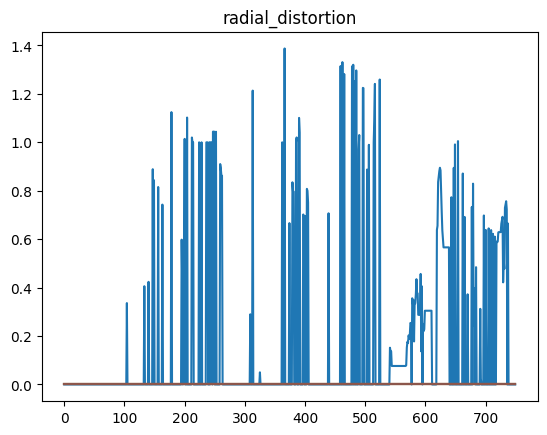

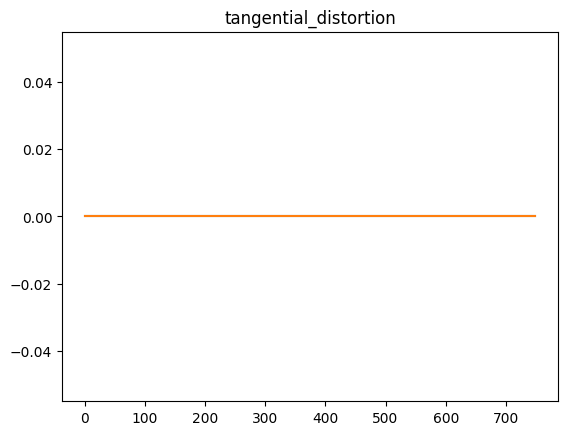

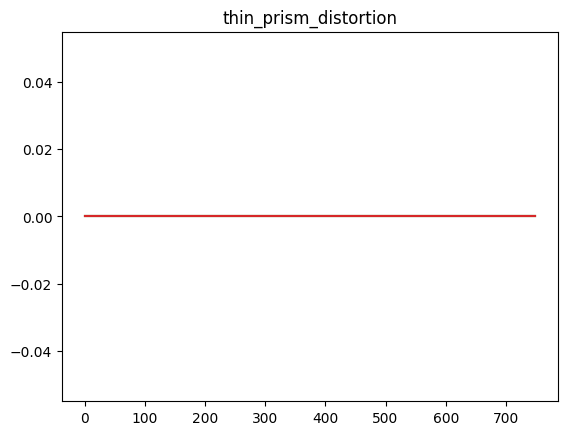

In [46]:
# plot each key in indCamParams in a subplot
for key in indCamParams.keys():
	plt.plot(indCamParams[key])
	plt.title(key)
	plt.show()

Linear interpolation of non complete camera parameters

In [47]:
xp = []
if not isNonCompleteParams[0] and isNonCompleteParams[1]:
	xp.append(0)
if not isNonCompleteParams[-1] and isNonCompleteParams[-2]:
	xp.append(len(camParams) - 1)
for i in range(1, len(camParams) - 1):
	if not isNonCompleteParams[i] and (isNonCompleteParams[i - 1] or isNonCompleteParams[i + 1]):
		xp.append(i)
for pos in posNonCompleteParams:
	camParams[pos] = tmpCompleteParam
print(posNonCompleteParams)
print(xp)

[207 210 222 235 237 248 249 251 256 262 271 279 286 293 317 333 355 358
 360 368 370 371 376 377 381 383 520 522 526 528 529 530 531 532 534 535
 536 537 538 539 540 543 545 546 547 548 549 550 551 552 553 554 555 556
 557 558 559 560 561 562 563 564 565 566 583 587 589 590 591 600 601 602
 603 604 605 606 607 608 609 610 612 613 614 615 616 617 618 631 632 633
 634 635 636 637 638 639 651 659 668 686 687 688 689 690 695 723 724 725]
[206, 208, 209, 211, 221, 223, 234, 236, 238, 247, 250, 252, 255, 257, 261, 263, 270, 272, 278, 280, 285, 287, 292, 294, 316, 318, 332, 334, 354, 356, 357, 359, 361, 367, 369, 372, 375, 378, 380, 382, 384, 519, 521, 523, 525, 527, 533, 541, 542, 544, 567, 582, 584, 586, 588, 592, 599, 611, 619, 630, 640, 650, 652, 658, 660, 667, 669, 685, 691, 694, 696, 722, 726]


In [48]:
for key, value in indCamParams.items():
	if len(value.shape) == 1:
		tmp = np.interp(posNonCompleteParams, xp, value[xp])
		indCamParams[key][posNonCompleteParams] = tmp
	else: # 2D array
		for i in range(value.shape[1]):
			tmp = np.interp(posNonCompleteParams, xp, value[xp, i])
			indCamParams[key][posNonCompleteParams, i] = tmp

In [49]:
indCamParamsInterp = deepcopy(indCamParams)

(108,) (108,)


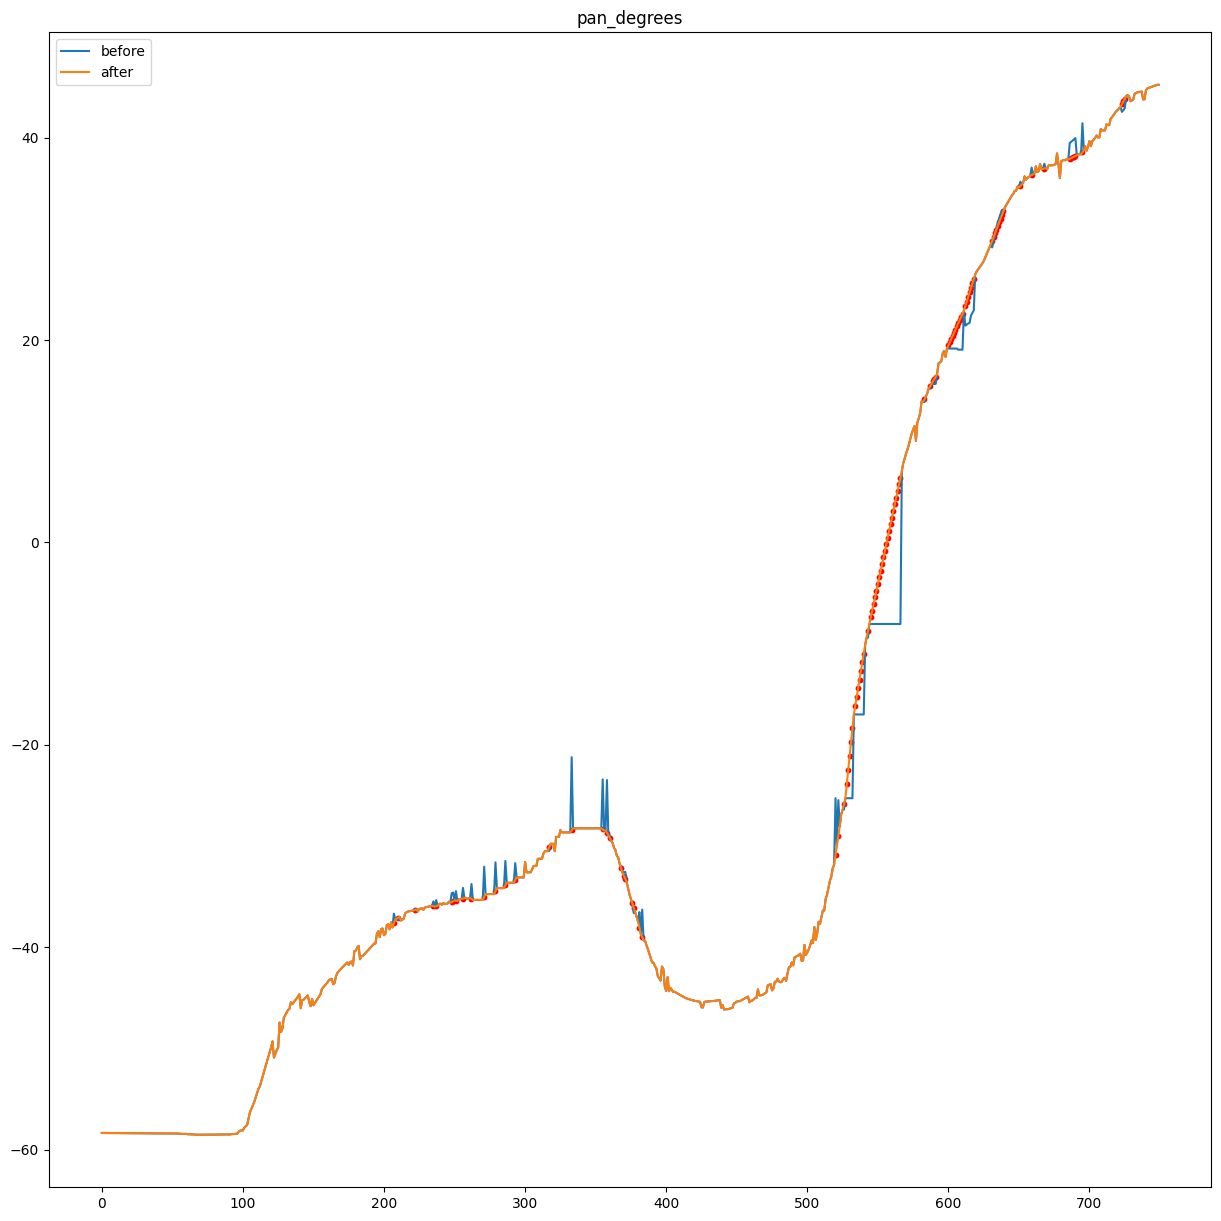

(108,) (108,)


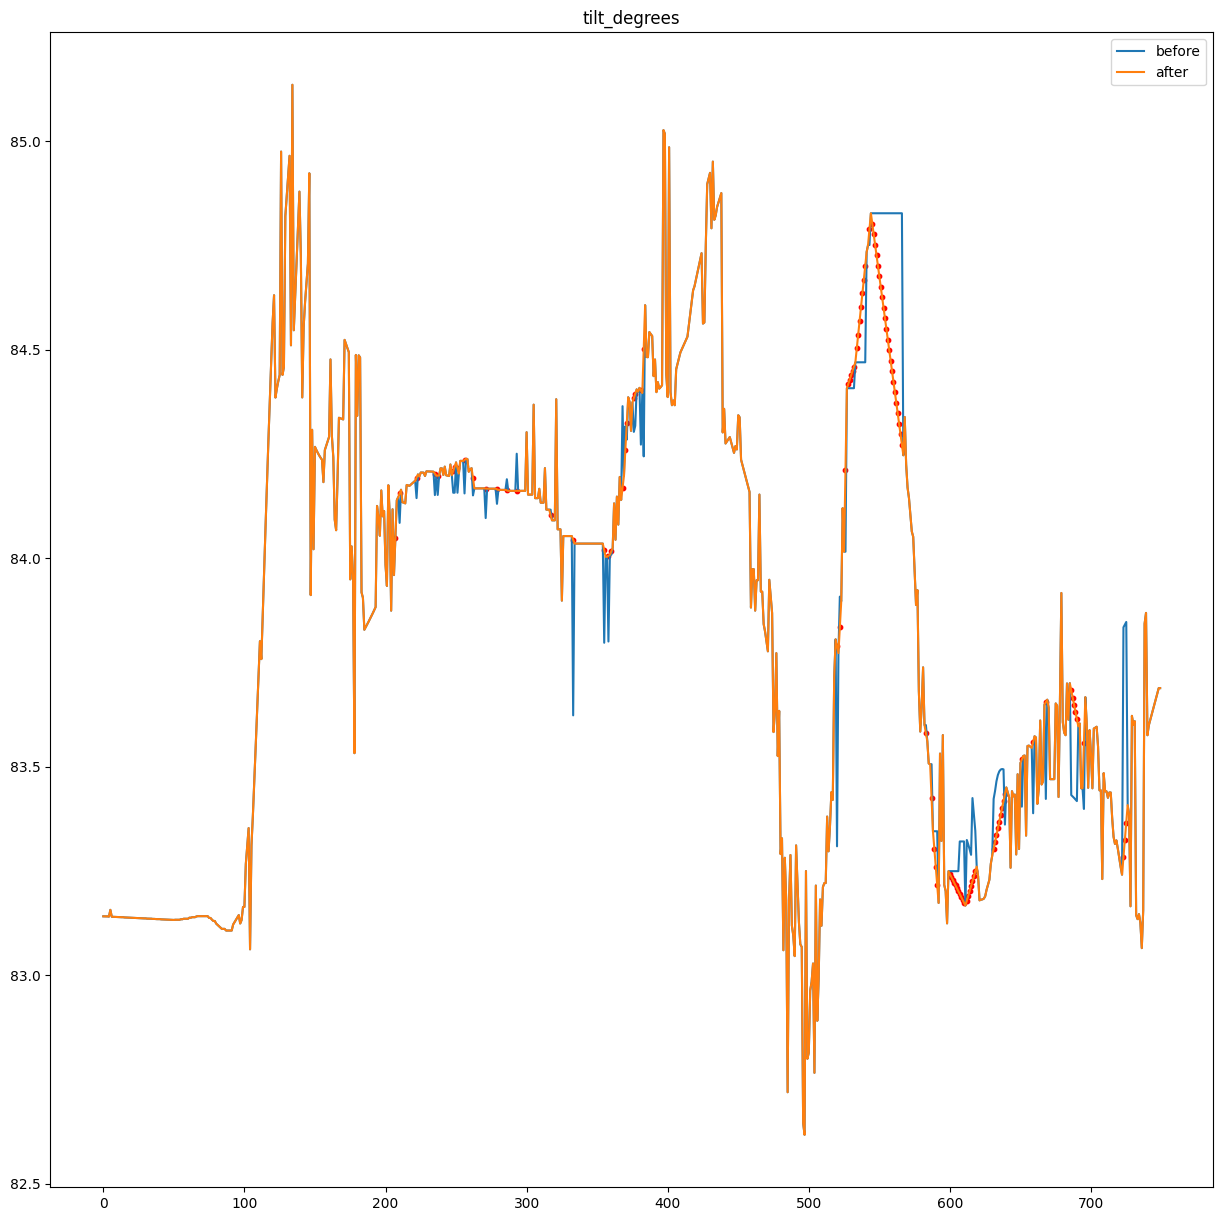

(108,) (108,)


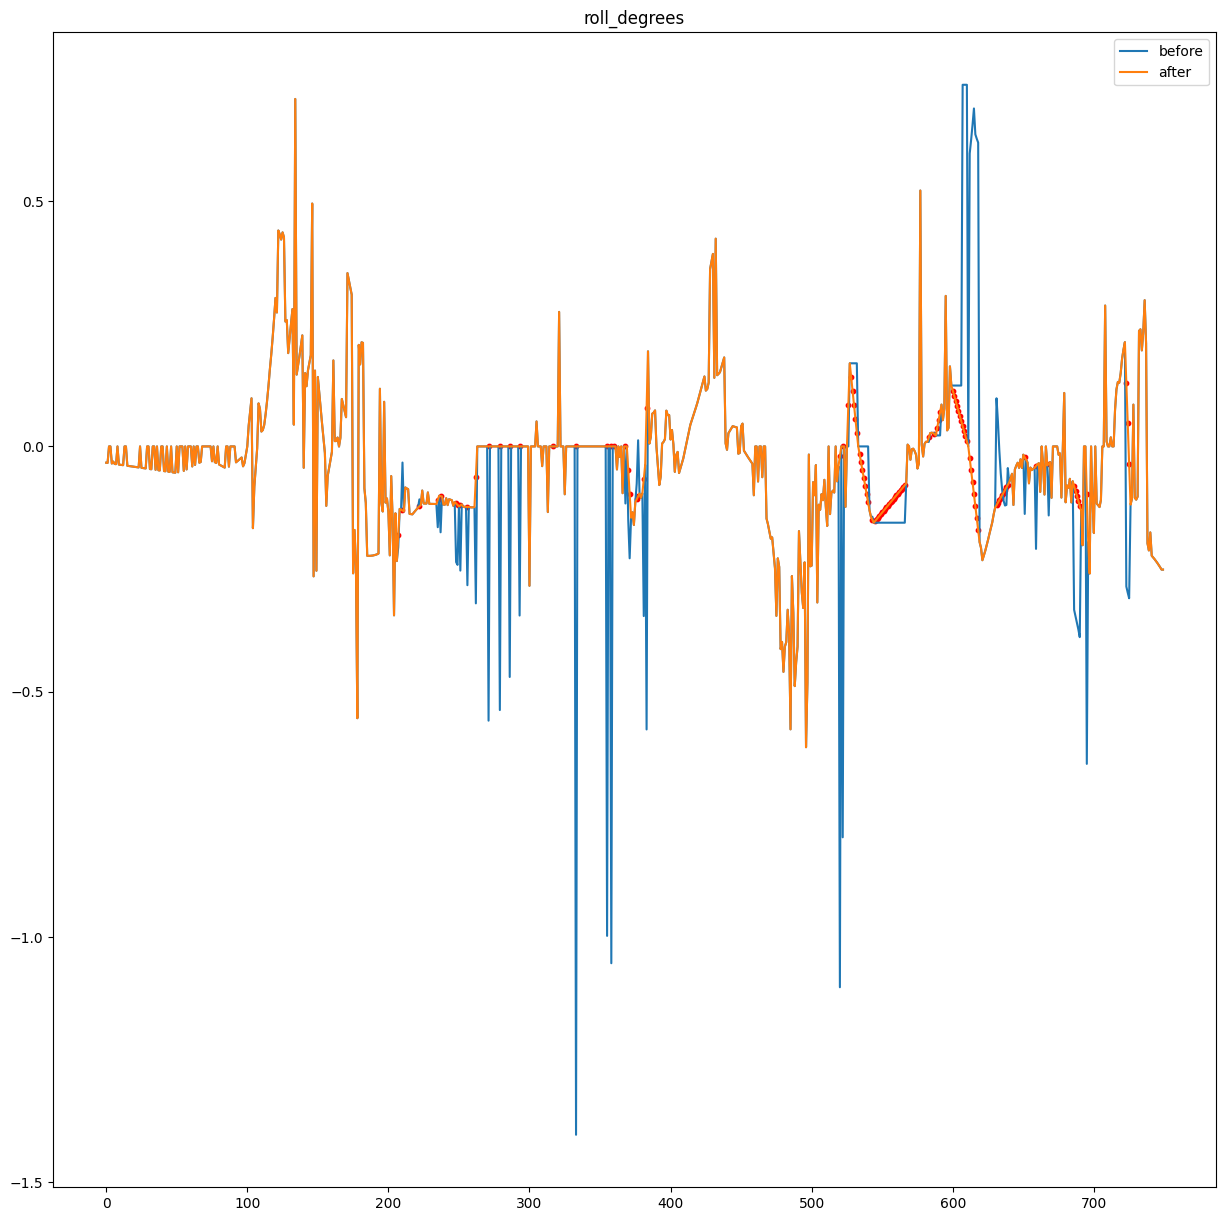

(108,) (108, 3)


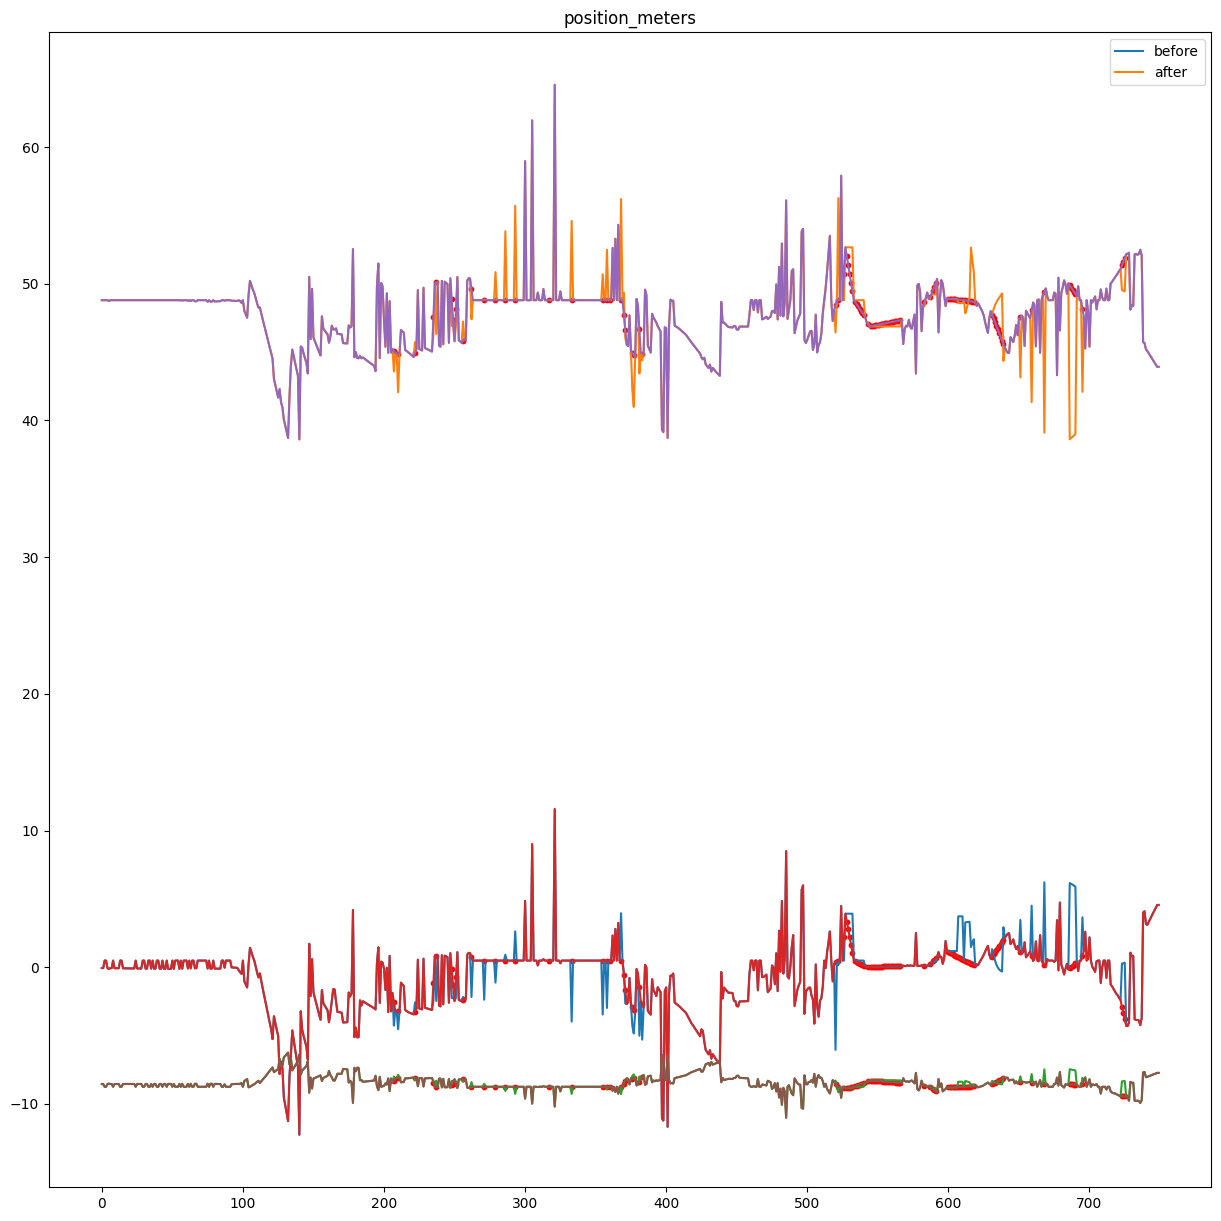

(108,) (108,)


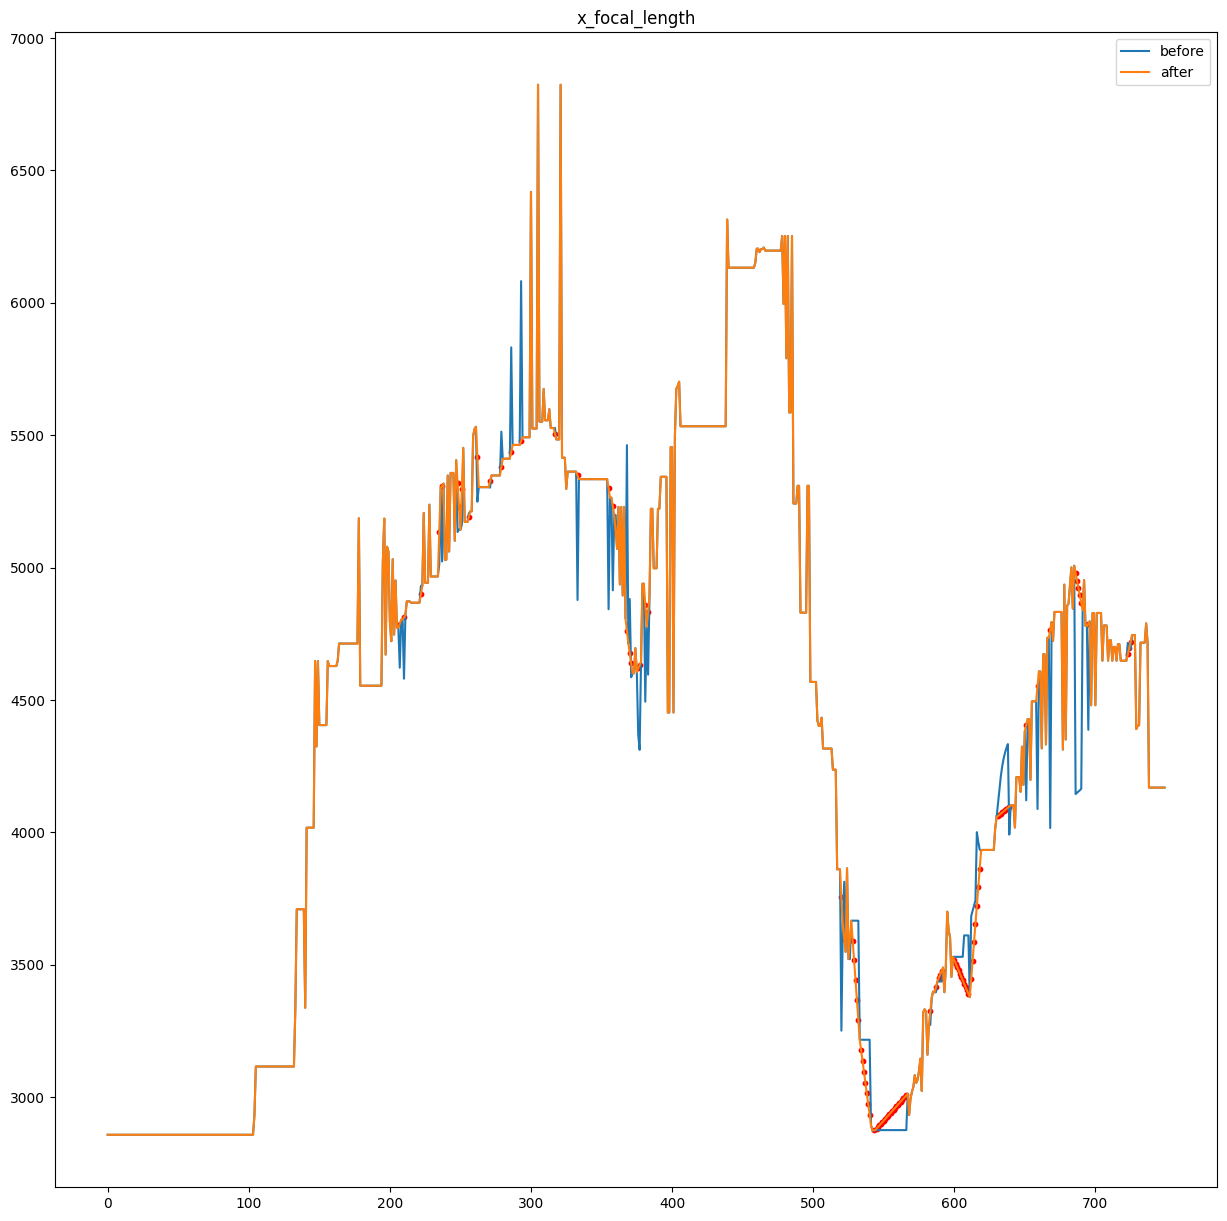

(108,) (108,)


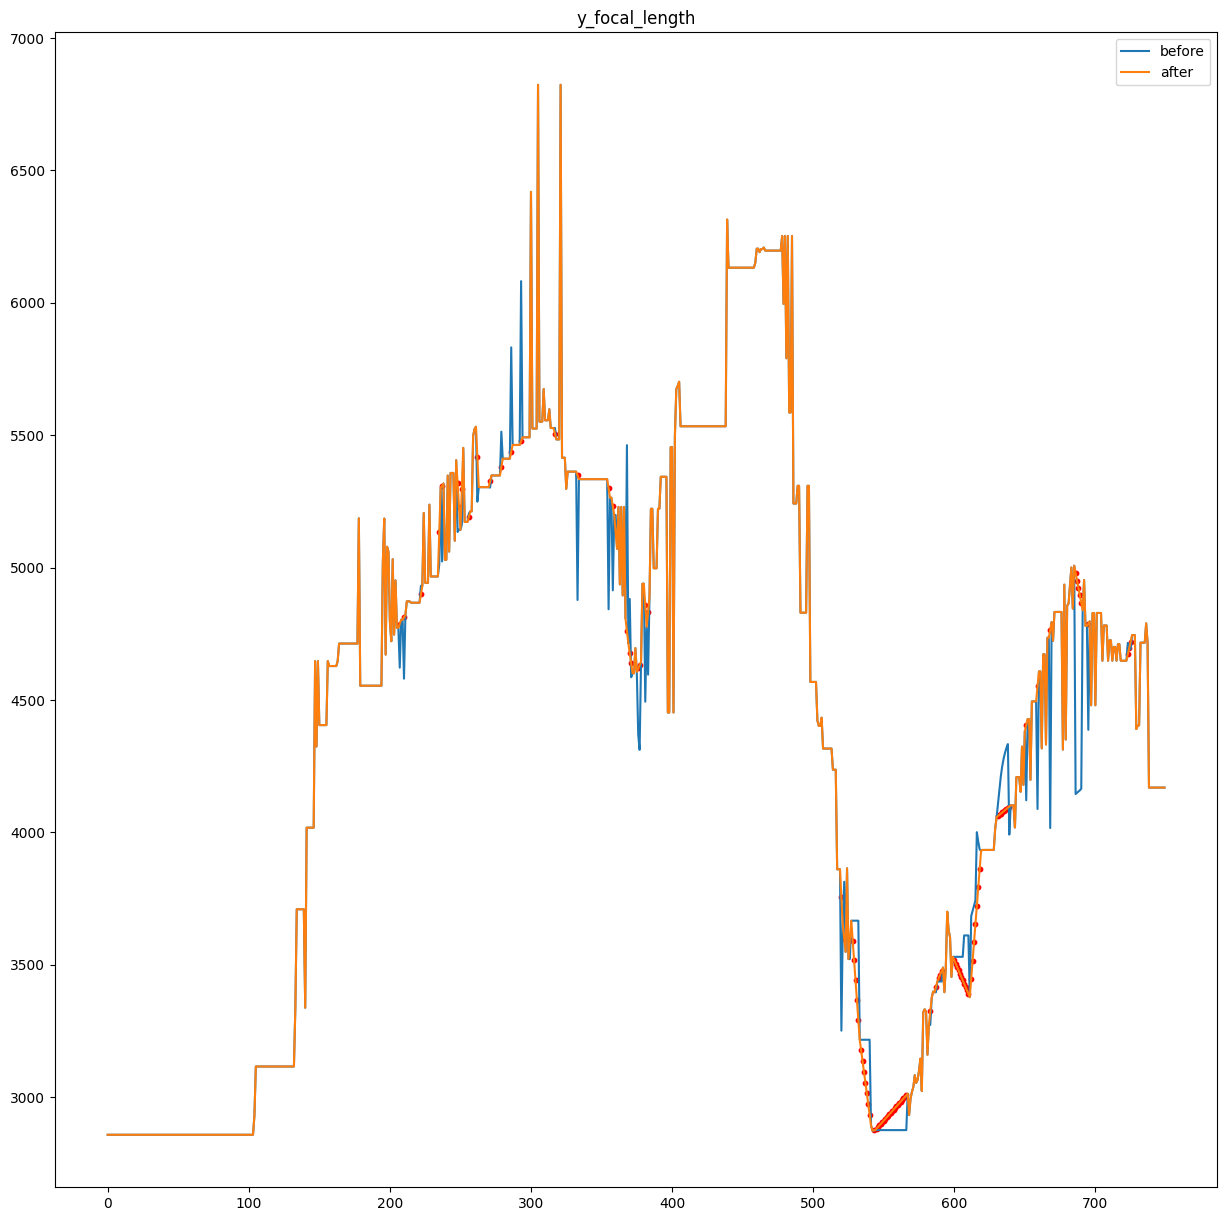

(108,) (108, 2)


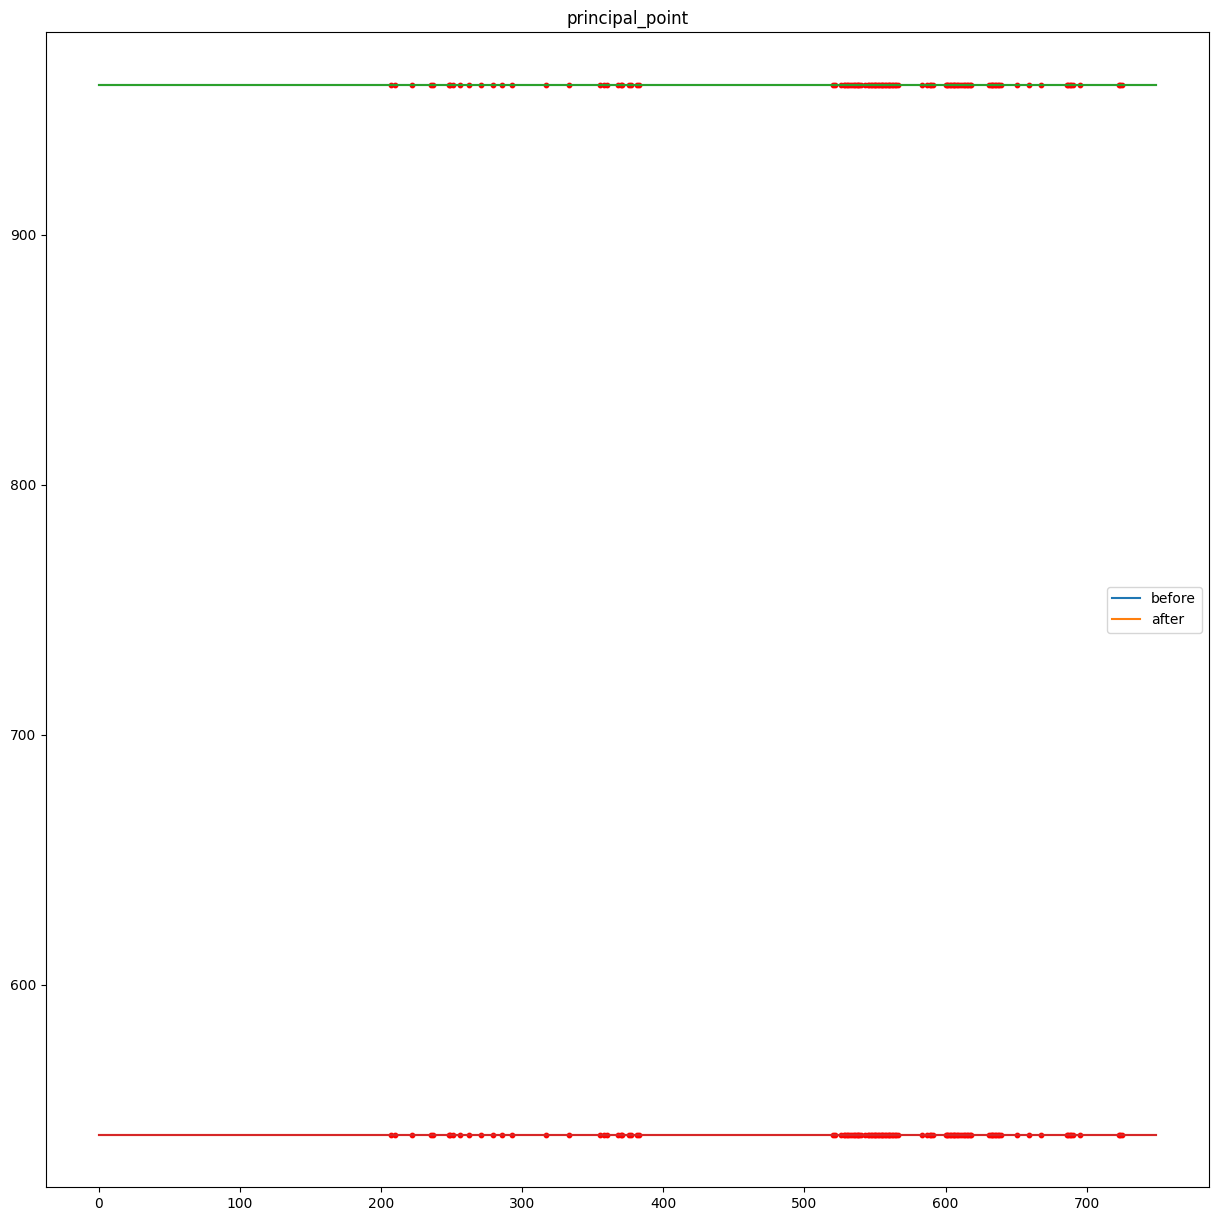

(108,) (108, 6)


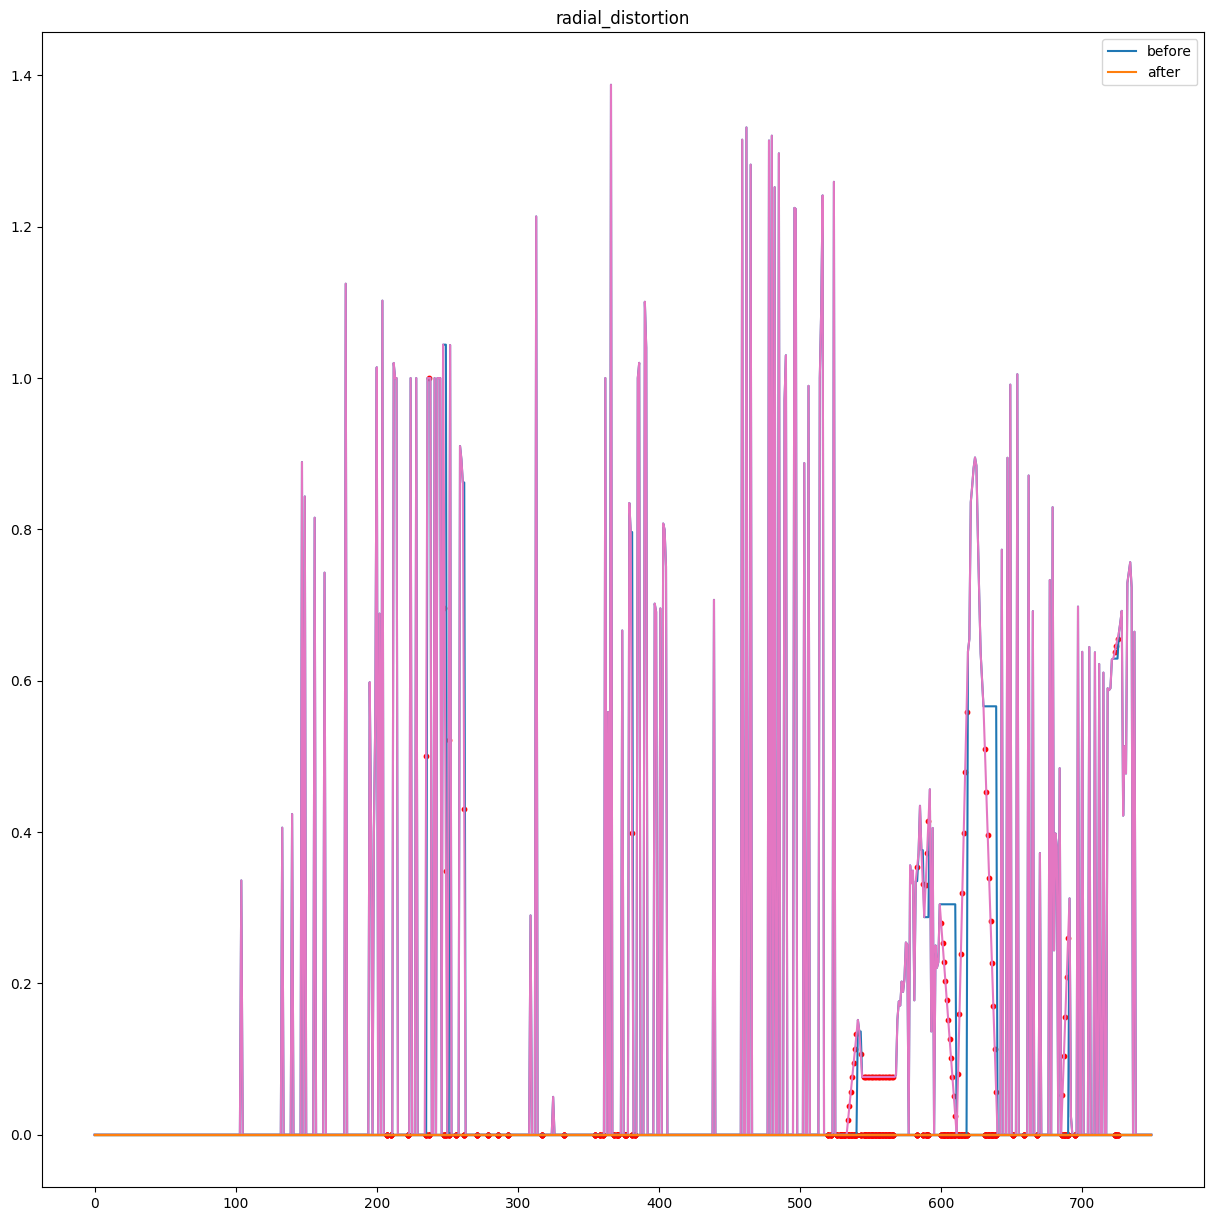

(108,) (108, 2)


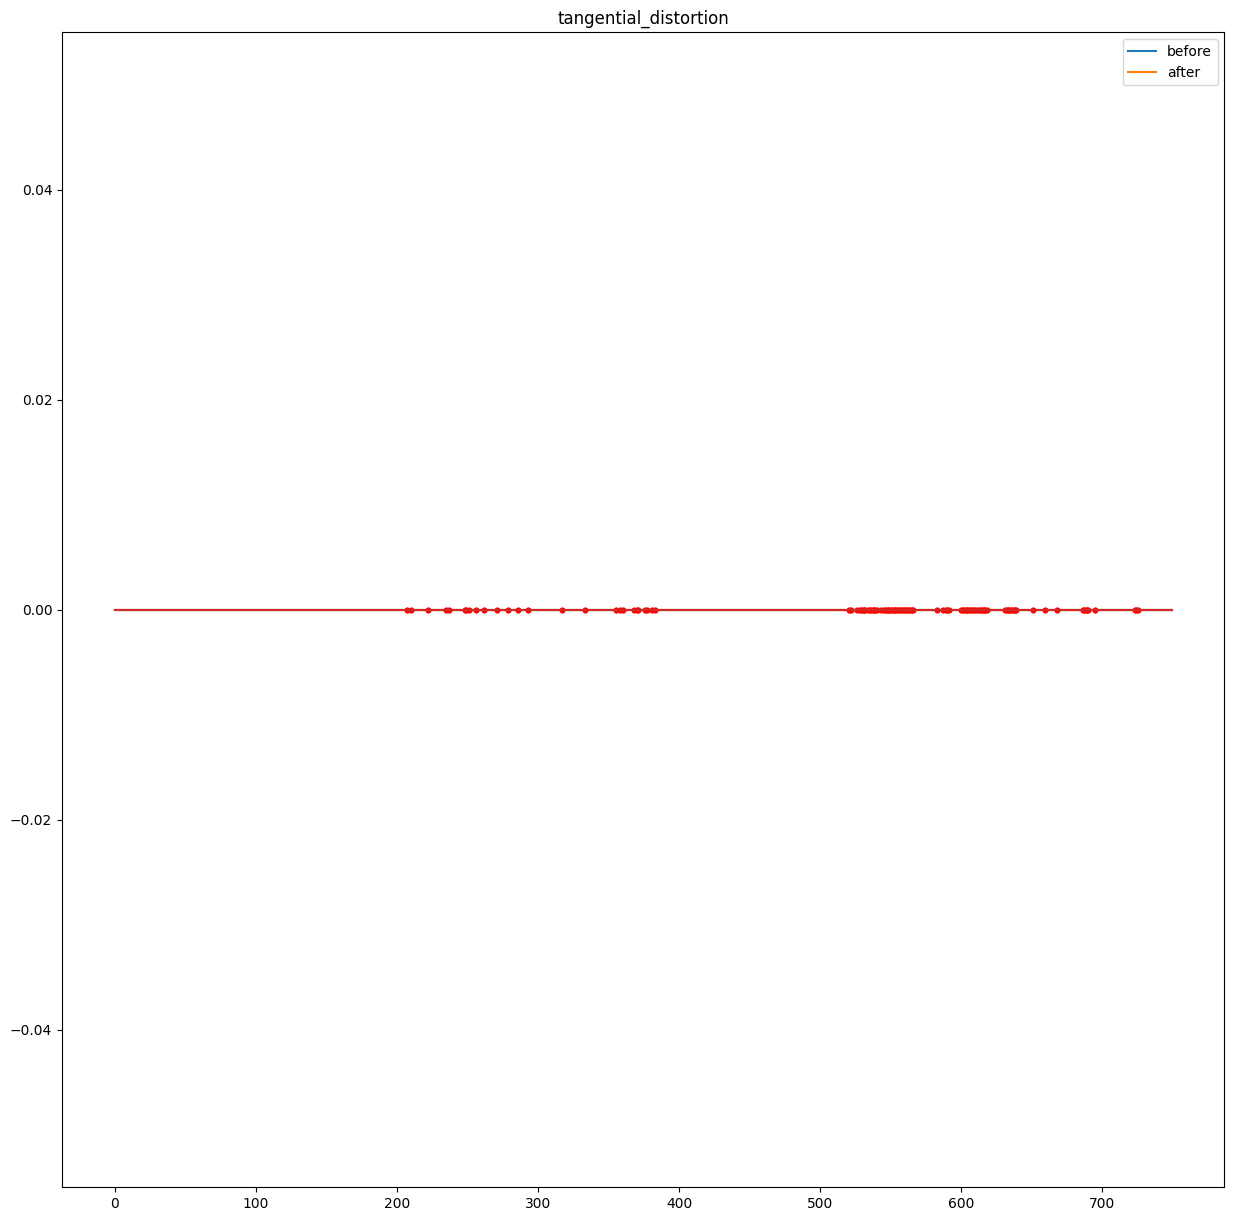

(108,) (108, 4)


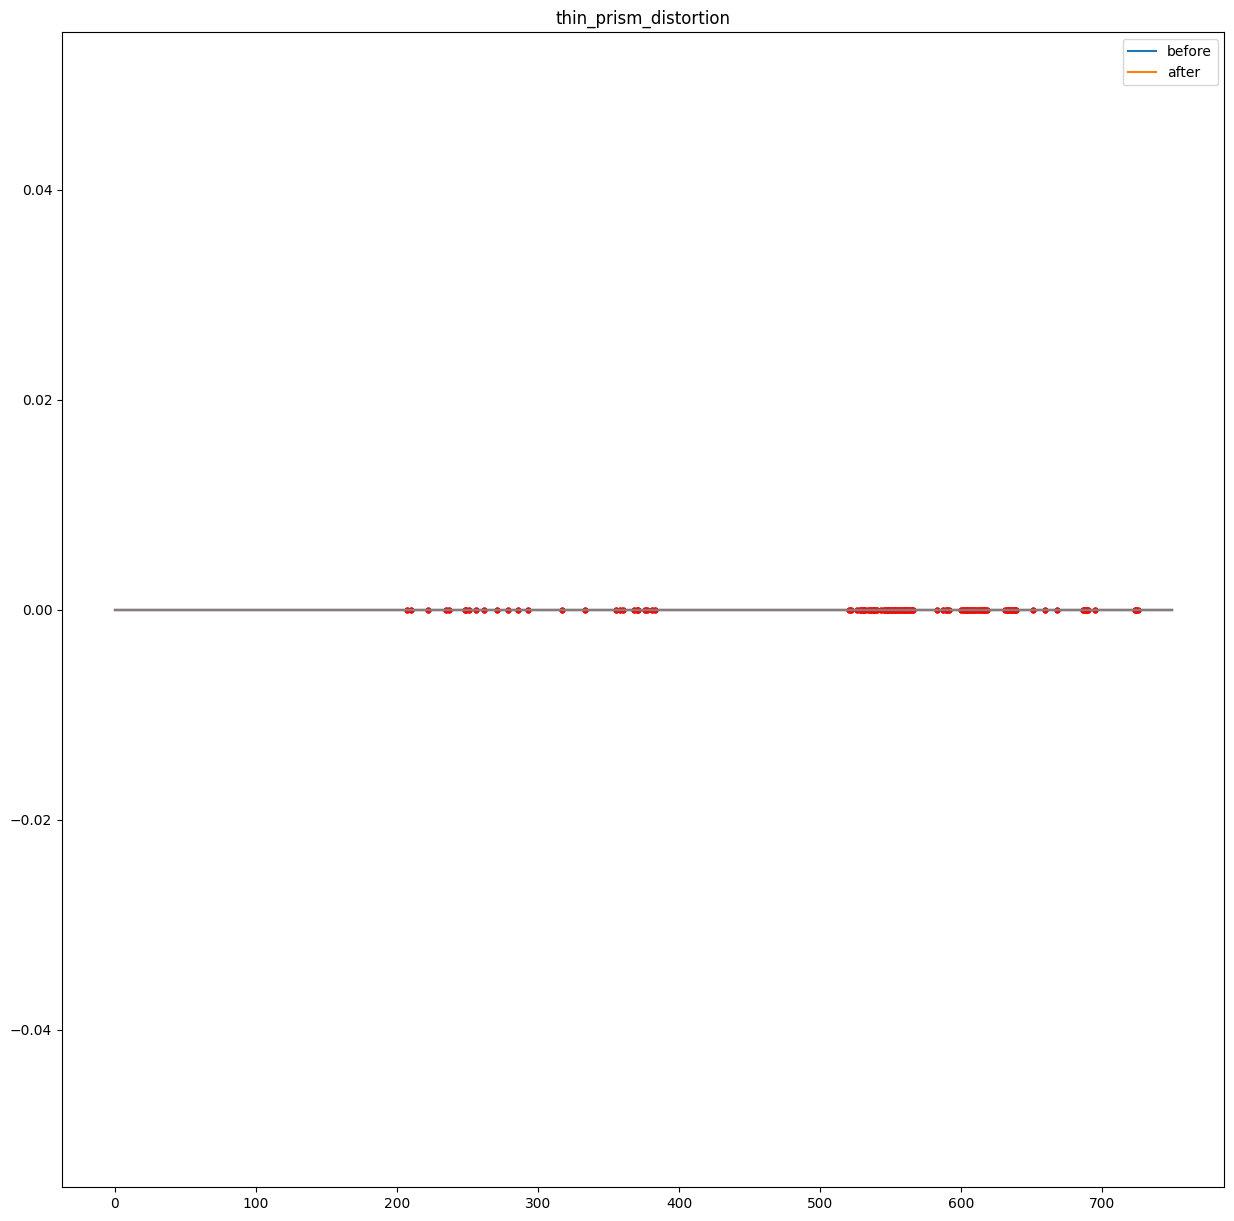

In [50]:
# plot each key in indCamParams in a subplot
for key in indCamParams.keys():
	plt.figure(figsize=(15, 15))
	plt.plot(indCamParamsOrig[key])
	plt.plot(indCamParams[key])
	plt.legend(["before", "after"])
	# plt points x=posNonCompleteParams, y=indCamParams[key][posNonCompleteParams]
	print(posNonCompleteParams.shape, indCamParams[key][posNonCompleteParams].shape)
	if len(indCamParams[key][posNonCompleteParams].shape) == 1:
		plt.scatter(posNonCompleteParams, indCamParams[key][posNonCompleteParams], color='red', s=10)
	else:
		for i in range(indCamParams[key][posNonCompleteParams].shape[1]):
			plt.scatter(posNonCompleteParams, indCamParams[key][posNonCompleteParams, i], color='red', s=10)
	plt.title(key)
	plt.show()

In [51]:
lngth = len(camParams)
smoothedIndCamParams = deepcopy(indCamParams)
for key in indCamParams.keys():
	smoothedIndCamParams[key] = savgol_filter(indCamParams[key], 25, 3, axis=0)

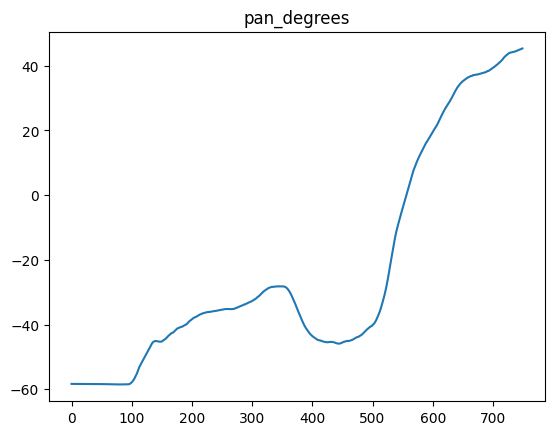

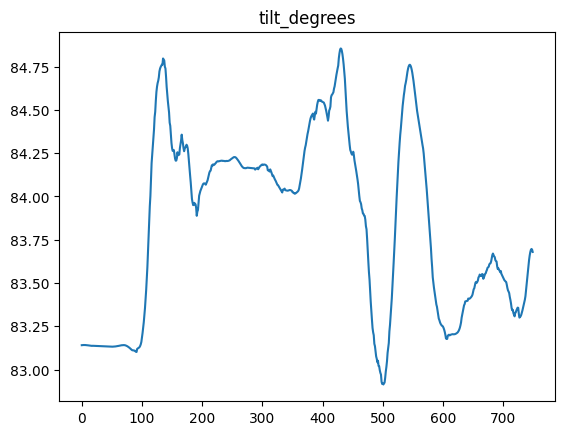

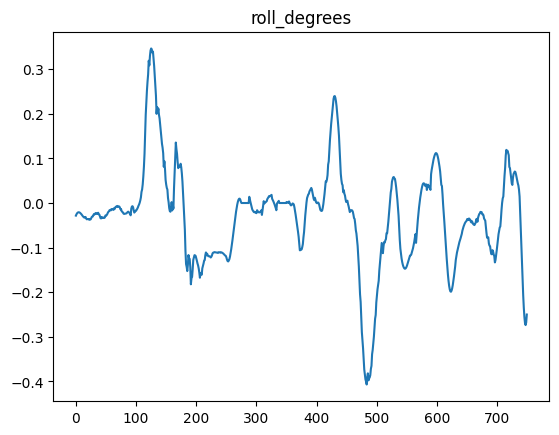

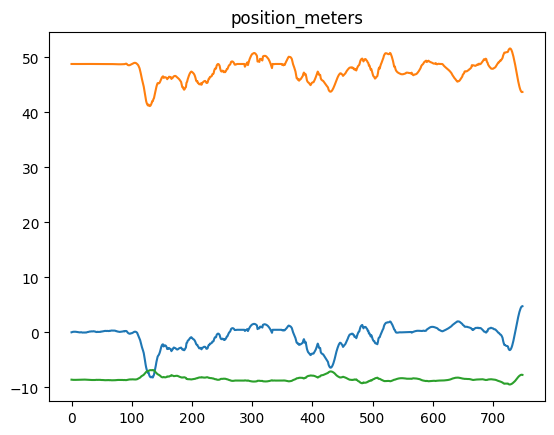

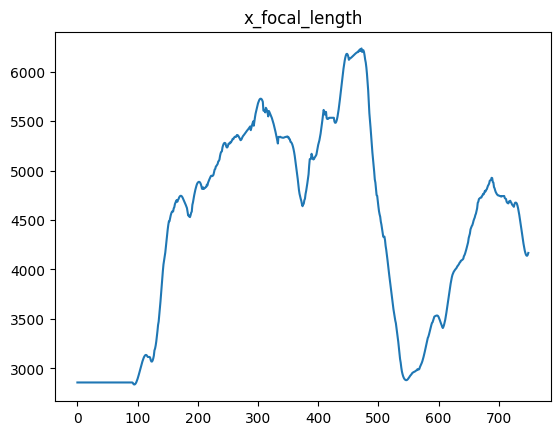

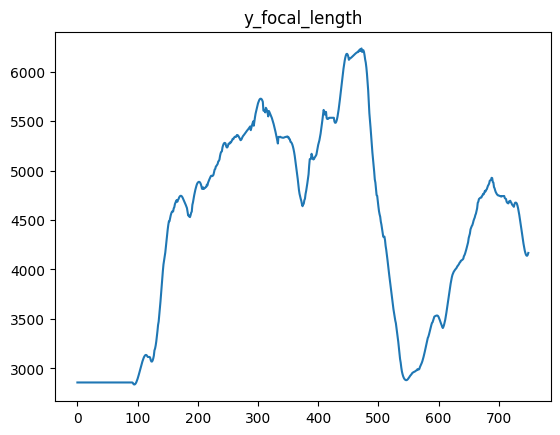

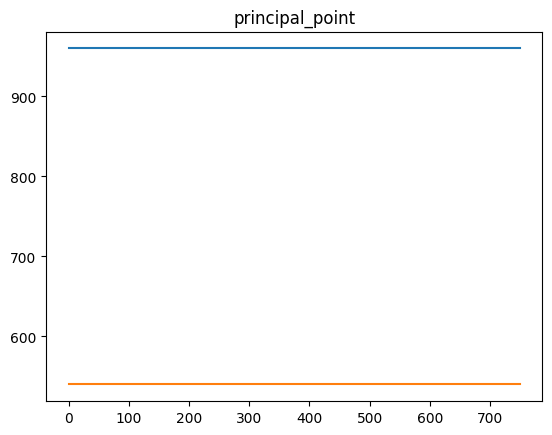

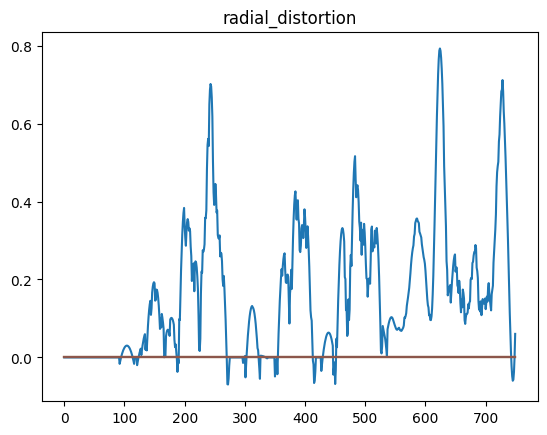

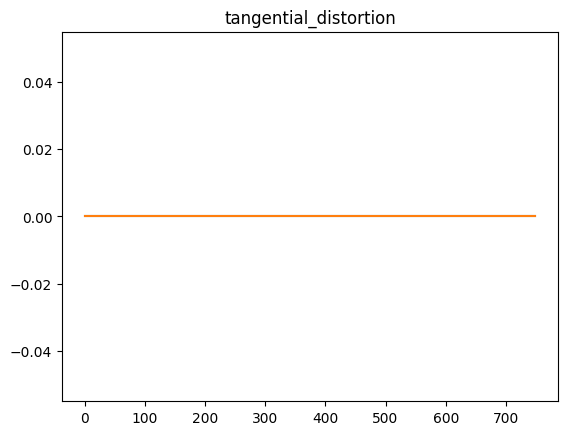

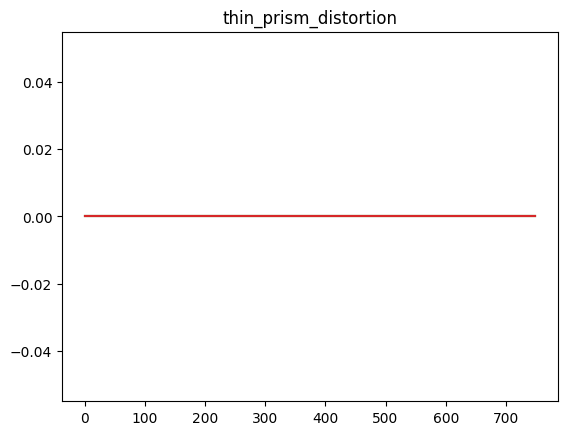

In [52]:
for key in smoothedIndCamParams.keys():
	plt.plot(smoothedIndCamParams[key])
	plt.title(key)
	plt.show()

In [53]:
origCamParams = [dict(zip(indCamParamsOrig.keys(), [indCamParamsOrig[key][i] for key in indCamParamsOrig.keys()])) for i in range(lngth)]
interpCamParams = [dict(zip(indCamParamsInterp.keys(), [indCamParamsInterp[key][i] for key in indCamParamsInterp.keys()])) for i in range(lngth)]

In [54]:
smoothedCamParams = [dict(zip(smoothedIndCamParams.keys(), [smoothedIndCamParams[key][i] for key in smoothedIndCamParams.keys()])) for i in range(lngth)]

In [55]:
# change ndarray in the dict to list
for i in range(lngth):
	smoothedCamParams[i]["position_meters"] = smoothedCamParams[i]["position_meters"].tolist()
	smoothedCamParams[i]["principal_point"] = smoothedCamParams[i]["principal_point"].tolist()
	smoothedCamParams[i]["radial_distortion"] = np.abs(smoothedCamParams[i]["radial_distortion"]).tolist()
	smoothedCamParams[i]["tangential_distortion"] = np.abs(smoothedCamParams[i]["tangential_distortion"]).tolist()
	smoothedCamParams[i]["thin_prism_distortion"] = np.abs(smoothedCamParams[i]["thin_prism_distortion"]).tolist()

In [56]:
mask_path = "out360/tta/"
path = 'Images/360'
imgs = os.listdir(path)
imgs.sort()
len(imgs)

750

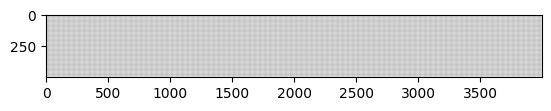

In [57]:
# Create a 1080x1920 grid image with white background, black lines and squares of 5x5 pixels
squareSize = 10
gridWidth = 4000
gridHeight = 500
grid = np.zeros((gridHeight, gridWidth, 3), dtype=np.uint8)
grid.fill(255)
for i in range(0, gridWidth, squareSize):
	cv2.line(grid, (i, 0), (i, gridHeight), (0, 0, 0), 1)
for i in range(0, gridHeight, squareSize):
	cv2.line(grid, (0, i), (gridWidth, i), (0, 0, 0), 1)
# plot grid
plt.imshow(grid)
# save image with a dpi of 300
# plt.imsave('grid.png', grid, dpi=300)

In [58]:
srcPoints = np.float32([[gridWidth//2, gridHeight-1], [gridWidth//2, gridHeight-1 - 3*squareSize], [gridWidth//2 + 3*squareSize, gridHeight-1 - 3*squareSize], [gridWidth//2 + 3*squareSize, gridHeight-1]])
worldDstPoints = np.float64([[0,-34,0], [0,-34,-1], [1,-34, -1], [1,-34,0]])
camParamsTypesDict = {
	type(None): -1,
	list: 0,
	dict: 1,
}
xLength = 25*1

In [65]:
def superimposeImage(imageName, iteration):
	img = cv2.imread(path + '/' + imageName)
	mask = cv2.imread(mask_path + imageName[:-4] + '.png', cv2.IMREAD_GRAYSCALE)  # type: ignore
	mask = np.bitwise_and(mask > 0, mask < 3)
	cam.from_json_parameters(interpCamParams[iteration])
	cam.draw_corners(cam.draw_pitch(img, color=(0, 0, 255)), color=(0, 0, 255))
	cam.from_json_parameters(smoothedCamParams[iteration])
	dstPoints = np.float32([cam.project_point(pt, distort=False)[:2] for pt in worldDstPoints])
	M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
	warpedGrid = cv2.warpPerspective(grid, M, (img.shape[1], img.shape[0]))
	img[mask] = warpedGrid[mask]
	cam.draw_corners(cam.draw_pitch(img))
	# if iteration >=  xLength - 1:
	# 	x = [i for i in range(iteration-xLength+1, iteration+1)]
	# 	y = [camParamsTypesDict[type(camJsonParams[i]["parameters"])] for i in range(iteration-xLength+1, iteration+1)]
	# 	# plot the data and put the plot in the image
	# 	plt.plot(x, y)
	# 	plt.ylim(-1.5, 1.5)
	# 	plt.savefig('plot.png')
	# 	plot = cv2.imread('plot.png')
	# 	# put the plot in the lower left corner of the image
	# 	img[img.shape[0]-plot.shape[0]:, :plot.shape[1]] = plot
	# 	plt.clf()
	return img

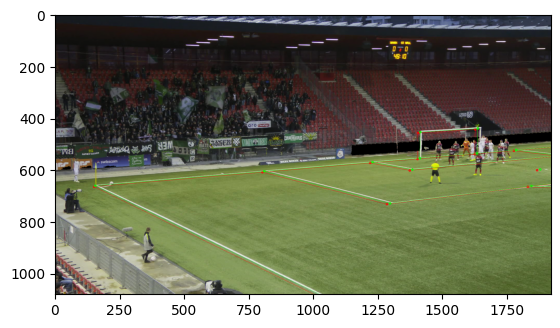

In [66]:
it=50
test = superimposeImage(imgs[it], it)
# change from BGR to RGB
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

In [67]:
# Get the first image
img = cv2.imread(path + '/' + imgs[0])
height, width, layers = img.shape
print(height, width, layers)

# Create a video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
video = cv2.VideoWriter('tmp.mp4', fourcc, 25, (width,height))

# Write all images to the video
for i in tqdm(range(len(imgs))):
	img = superimposeImage(imgs[i], i)
	video.write(img)

# Close the video writer
video.release()

1080 1920 3


100%|██████████| 750/750 [02:17<00:00,  5.46it/s]
